# DeepGANnel

A GAN made to generate synthetic ion channel data from previously recorded data, using a CNN model.

In [1]:
# Imports
import os, sys, socket
import random
import glob
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from statistics import mean
from copy import deepcopy
from tqdm import tqdm

import time
from datetime import datetime

from tensorflow.keras import layers
from sklearn.preprocessing import minmax_scale, RobustScaler,robust_scale
from IPython.display import clear_output

# Experimental - adding 1/f noise instead of gaussian noise

#from colorednoise import powerlaw_psd_gaussian

In [2]:
#Datasource
datafolder='PYRdata'
# Constants
# Have only verified 50, 100, 250
BATCH_SIZE = 100
# Have only verified 512, 1024, 2048, 4096
WINDOW_SIZE = 2048

#Add a little noise to facilitate CNN "throughout"
NOISE_AMP = 0.01

#0 is accept records that are all one state; 0.5 is,accept only records with more than 50% of each state
#Not sure what happens with 0.5 or more so recommend range of 0 to 0.25
#Note if too high preprocess data will loop indefinitely at some stage.
THRESHOLD = 0.2

#Try a critic approach rather than strictly discriminator
Wasserstein=True
ADAMO=True
scripts = glob.glob('*.ipynb')
myPC=socket.gethostname()
with open ("runs.txt","a") as runs:
    runs.write(f"This PC is {myPC}\nDate is {datetime.now()}\nTF= {tf.__version__}\n")
    runs.write(f"Script name: {scripts}\n")
    runs.write(f"Wasserstein was used? {Wasserstein}\n")
    runs.write(f'Adam used (SGD if false) {ADAMO}')
    runs.write(f"BATCH_SIZE = {BATCH_SIZE}, WINDOW_SIZE = {WINDOW_SIZE}, NOISE_AMP = {NOISE_AMP}, THRESHOLD = {THRESHOLD}\n\n")


## Step 1: Preprocessing data

First job is to sort the data to obtain batches. Discard any window that has no events in as the GAN will just output noisy "flat" data that isn't useful! We'll then save this data to use later on. We know the data is scaled so we don't need to do that here.

In [3]:
def check_window(channel_record: np.ndarray) -> bool:
    
    """ Returns True if there is an event in the window """
    
    """return True if (1 in channel_record[:,1:]) and (0 in channel_record[:,1:]) else False"""
    """toughen this up, want more than one single event :-)"""
    threshold = THRESHOLD
    total=len(channel_record[:,1])
    opens=len(channel_record[channel_record[:,1]==1])
    val=True if ((opens/total >threshold) and (opens/total <(1-threshold))) else False
    """plt.plot(channel_record[:,0])
    plt.plot(channel_record[:,1])
    plt.show()
    
    print('                                                                   ',end='\r')   
    print(f' length = {total}, open={opens}, frac={opens/total:.2f} so return={val}', end='\r')
    if val == False:
        time.sleep(1)"""
    return val
    
def preprocess_data() -> ():
    
    """ 
    Preprocessing data into one large numpy array - along with a list of
    marker start indexes for randomly sampling batches.
    
    If an index < marker AND index + WINDOW_SIZE > marker, they'll be a change
    of file in the window, therefore it's invalid.
    """
    
    cwd = os.getcwd()
    """alternatives
    files = os.listdir(f'{cwd}/synth_data')
    files = glob.glob('synth_data/*.csv')"""
    files = glob.glob(f'{datafolder}/*.csv')
    print(files)
    outer_index = 1
    markers = []
    output_data = np.array([[0,0]])
    for filename in files:
        print(f'Processing {filename}')
        """currently starting from row 2 incase headers etc"""
        inner_index = 0
        active = False
        """for the funky file"""
        funky=False
        if funky:
            print("funky")
            data1 = pd.read_csv(filename).values[2:,5].reshape(-1,1)
            """channel"""
            data2 = pd.read_csv(filename).values[2:,2] .reshape(-1,1)
            data=np.concatenate((data1,data2),axis=1).reshape(-1,2).astype(np.float)
        """print (np.amin(data[:,1]),np.amax(data[:,1]))"""
        Nat=False
        if Nat:
            data = pd.read_csv(filename).values[2:,1:]
            """if accidently flipped channel and current!"""
            data[:,[0,1]]=data[:,[1,0]]
            print(data)
            simplify=False
            if simplify:
                for row in data:
                    """print(row)"""
                    if row[1]==3:
                        row[1]=1
                    elif row[1]==2:
                        row[1]=0
                    else:
                        row[1]=0
            simplify2=False
            if simplify2:
                for row in data:
                    """print(row)"""
                    if row[1]==2:
                        row[1]=1
                    elif row[1]==1:
                        row[1]=0
                    elif row[1]==0:
                        row[1]=0
                    else:
                        row[1]=1
        else:
            data = pd.read_csv(filename).values[2:,1:]
        '''round idealisation to 0 and 1
        this is typically, but not always necessary depending on record source'''
        data[:,1]=np.round(data[:,1])
        data[:,1]=data[:,1]/np.max(data[:,1])
        data[:,1]=np.round(data[:,1])
        
        print('data.shape',data.shape)
        print('data type', type(data))
        print('data snapshot',data)
        savechange=False
        if savechange:
            ddict = {'1cur': data[:, 0],
            '2chan': data[:, 1]}
            df = pd.DataFrame (ddict, columns = ['1cur','2chan'])
            print (df)
            df.to_csv('filename.csv', index =False, header=False)           
            
        """data=data[~(data[:,1] > 1)]    
        print (np.amin(data[:,1]),np.amax(data[:,1]))"""

        for i in range(len(data)):
            window_check = check_window(data[i:i+WINDOW_SIZE, :])
            markers.append(window_check)
            if window_check and not active:
                # Start recording - make a note of the inner index.
                inner_index = i
                active = True
            elif not window_check and active:
                
                # Stop "recording" and save the file to the output data.
                # Also make a marker for safe indexing later.
     
                window_to_save = data[inner_index: i + WINDOW_SIZE - 1, :]
                end_index = outer_index + i + WINDOW_SIZE - 1
                
                output_data = np.concatenate((output_data, window_to_save))
                """markers.append(end_index)"""
                               
                active = False
        outer_index = len(output_data)
    print(len(data),len(markers))    
    """return (output_data, markers)"""
    print(markers[:10])
    print(f'Number of good windows is {len([marker for marker in markers if marker==True])}')
    return (data, markers)
    
preprocessed_data, markers = preprocess_data()

['PYRdata\\combinedpyroriginCUT.csv']
Processing PYRdata\combinedpyroriginCUT.csv
data.shape (73316, 2)
data type <class 'numpy.ndarray'>
data snapshot [[-0.17103  0.     ]
 [-0.26987  0.     ]
 [-0.22052  0.     ]
 ...
 [-0.42251  0.     ]
 [-0.02274  0.     ]
 [ 0.42643  0.     ]]
73316 73316
[False, False, False, False, False, False, False, False, False, False]
Number of good windows is 49255


In [4]:
print(markers[:10])
print(f'Number of good windows is {len([marker for marker in markers if markers!=True])}')

[False, False, False, False, False, False, False, False, False, False]
Number of good windows is 73316


In [5]:
# Roughly how many valid windows do we have?
print(len(preprocessed_data)/len(markers))

1.0


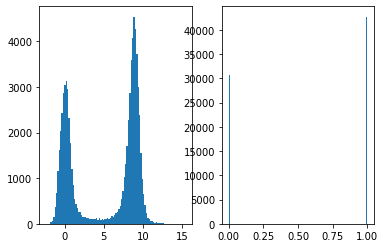

In [6]:
plt.subplot(1,2,1)
n, bins, patches =plt.hist(preprocessed_data[:,0],bins=100)
plt.subplot(1,2,2)
n, bins, patches =plt.hist(preprocessed_data[:,1],bins=100)
#plt.xlim([-0.6,0.4])
#plt.xlim([-0.6,0.4])
data = {'1cur': preprocessed_data[:,0],
                '2chan': preprocessed_data[:,1]}
df = pd.DataFrame (data, columns = ['1cur','2chan'])
#print (df)
df.to_csv(f'{WINDOW_SIZE}PYRraw.csv', index =False, header=False)

In [7]:
"""Minmax scale the current on the whole bloody lot"""
"""preprocessed_data[:,0]=minmax_scale(preprocessed_data[:, 0])"""
scaler=RobustScaler().fit(np.asarray(preprocessed_data[:,0]).reshape(-1,1))
x=scaler.transform(np.asarray(preprocessed_data[:,0]).reshape(-1,1))/2.0
"""rather late spotted that doing it with the below leaves no chance to inverse it!
so now creating a scale option that can be used at the end to unscale it back to meet the original"""
preprocessed_data[:,0]=robust_scale(preprocessed_data[:,0])/2.0
print (np.amin(preprocessed_data[:,1]),np.amax(preprocessed_data[:,1]))
print (np.amin(preprocessed_data[:,0]),np.amax(preprocessed_data[:,0]))
print(preprocessed_data.shape)
print(type(preprocessed_data))


0.0 1.0
-0.5974715669313736 0.43086066280875346
(73316, 2)
<class 'numpy.ndarray'>


## Step 2: Building Models

Here we are using two CNN models for the generator and discriminator - we also need to build the loss functions and optimizers for the two models.

In [8]:
def make_generator_model() -> tf.keras.Model:
    """
        Makes the generator model.
    """
    model = tf.keras.Sequential(name="Generator")

    model.add(layers.Dense(2*16*64, use_bias=False, input_shape=(WINDOW_SIZE,), dtype='float32'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 16, 64)))
    assert model.output_shape == (None, 2, 16, 64) # Note: None is the batch size

    size = 16
    while size < WINDOW_SIZE/2:

        num_filters = 128 if size < 512 else 256

        model.add(layers.Conv2DTranspose(num_filters, (2, 5), strides=(1, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        size *= 2

    model.add(layers.Conv2DTranspose(1, (2, 5), strides=(1, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None, 2, WINDOW_SIZE, 1)

    return model

def make_discriminator_model() -> tf.keras.Model:
    """
        Makes the discriminator model.
    """
    model = tf.keras.Sequential(name="Discriminator")

    model.add(layers.Conv2D(32, (2, 100), strides=(1, 2), padding='same', input_shape=[2, WINDOW_SIZE, 1],dtype='float32'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (2, 50), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (2, 25), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output) -> float:        
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   
    if Wasserstein==True:
        fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        total_loss =real_loss - fake_loss
    else:
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output) -> float:
    return cross_entropy(tf.ones_like(fake_output), fake_output)


if ADAMO==True:
    # Optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-3)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)
else:
    #Otherwise just used SGD
    generator_optimizer = tf.keras.optimizers.SGD(1e-6)
    discriminator_optimizer = tf.keras.optimizers.SGD(1e-6)


# Now build everything.
generator = make_generator_model()
discriminator = make_discriminator_model()    
    
    
    
#it appears that the change_lrs() is currently impotent.
def change_lrs(old_gen_lr: float, 
               old_disc_lr: float, 
               gen_loss_history: list, 
               disc_loss_history: list,
               reduction_factor: int = 2, 
               threshold_factor: int = 5, 
               history_length: int = 10):
    # Changing the learning rates dynamically based on the last 100 epochs 
    # If either model has a loss 5x the other over hte last 10 training steps,
    # multiply the "bad" model's learning rate by a factor (default 2) and
    # divide the "good" model's learning rate by the same amount
    
    # Also allow switching from "automatic" to "manual" using a text file "lr.txt"
    
    with open("lr.txt", "r+") as my_file:
        data = my_file.read()

        split = data.split('\n')
        automatic = True if "True" in split[0] else False
        new_gen_lr = 0
        new_disc_lr = 0

        if automatic:
            # Automatic method ONLY LIKELY TO WORK IF POSITIVE LOSSES ALL AROUND
            if len(gen_loss_history) == 0:
                # If no history, keep it how it is
                return old_gen_lr, old_disc_lr
            
            elif history_length > len(gen_loss_history):
                mean_recent_gen = mean(gen_loss_history[-history_length:])
                mean_recent_disc = mean(disc_loss_history[-history_length:])
            else:
                mean_recent_gen = mean(gen_loss_history)
                mean_recent_disc = mean(disc_loss_history)
                
            if mean_recent_gen >= threshold_factor * mean_recent_disc:
                new_gen_lr = old_gen_lr / 5
                new_disc_lr = old_disc_lr * 5
            elif mean_recent_disc >= threshold_factor * mean_recent_gen:
                new_disc_lr = old_disc_lr / 5
                new_gen_lr = old_gen_lr * 5
                
            else:
                new_disc_lr = old_disc_lr
                new_gen_lr = old_gen_lr
                    
        else:
            # Manual method
                
            parse_lr_from_file = lambda string: float(string.split(":")[1])
            new_gen_lr = parse_lr_from_file(split[1])
            new_disc_lr = parse_lr_from_file(split[2])
            
        tf.keras.backend.set_value(generator_optimizer.learning_rate,new_gen_lr)
        tf.keras.backend.set_value(discriminator_optimizer.learning_rate,new_disc_lr)
        # Save the new data
        new_data = f"AUTOMATIC : {automatic}\nGENERATOR_LEARNING_RATE : {new_gen_lr}\nDISCRIMINATOR_LEARNING_RATE : {new_disc_lr}"
        my_file.seek(0)
        my_file.truncate(0)
        my_file.write(new_data)

    return new_gen_lr, new_disc_lr
    


In [9]:
# Checkpoints and image generation
checkpoint_dir = "training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

def getREALepoch() -> int:
    """
    Save the current image to the working directory of the program.
    """
    currentImages = glob.glob("images/*.png")
   
    numList = [0]
    for img in currentImages:
        i = os.path.splitext(img)[0]
        try:
            num = re.findall('[0-9]+$', i)[0]
            numList.append(int(num))
        except IndexError:
            pass
    numList = sorted(numList)
    return numList[-1]+1

def unscale_images(data: np.array) -> np.array:
    """assumes scaler sitting in the global space"""
    for i in range(len(data[:,0,0,0])):
        tempx=data[i,0,:,0].reshape(1,-1)*2
        #tempx=scaler.inverse_transform(data[i,0,:,0].reshape(-1,1)*2).reshape(1,-1,1)
        tempx=scaler.inverse_transform(tempx).reshape(1,-1,1)
        tempy=data[i,1,:,0].reshape(1,-1,1)
        tempxy=np.stack((tempx,tempy),axis=1)
        if i==0:
            newdata=tempxy
        else:
            newdata=np.append(newdata,tempxy,axis=0)   
    newdata=np.asarray(newdata)  
    return newdata


def make_images(model, epoch, gen_loss_list, disc_loss_list,plot=True):
    me=random.randrange(BATCH_SIZE)
    noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE])
    generated_output = np.asarray(model(noise, training = False))
    """print(generated_output.shape)
    print(type(generated_output))"""
    generated_output=np.copy(generated_output)
    rawidl=generated_output[me, 1, :, 0].copy()
    """print(generated_output.flags)"""
    twostate=False
    if twostate:
        if generated_output[me, 1, 0, 0] >= 0.5:
            generated_output[me, 1, 0, 0]=1
        else:
            generated_output[me, 1, 0, 0]=0  
    
    thresh=0.6
    if twostate:
        for i in range(1,WINDOW_SIZE):
            if generated_output[me, 1, i-1, 0]==0:
                if generated_output[me, 1, i, 0]<thresh:
                    generated_output[me, 1, i, 0]=0
                else:
                    generated_output[me, 1, i, 0]=1
            if generated_output[me, 1, i-1, 0]==1:
                if generated_output[me, 1, i, 0]>1-thresh:
                    generated_output[me, 1, i, 0]=1
                else:
                    generated_output[me, 1, i, 0]=0            

    generated_output[:, 1, :, 0]=np.round(generated_output[:, 1, :, 0])
    generated_output[:, 1, :, 0]=np.clip(generated_output[:, 1, :, 0],0,1)
    
    %matplotlib inline
    ax1_length = generated_output.shape[2]
    plt.figure(figsize=[10,4])
    plt.plot(range(ax1_length), generated_output[me, 0, :, :], label="Current")
    plt.plot(range(ax1_length), generated_output[me, 1, :, :],'r-', label="Channels")
    plt.plot(range(len(rawidl)), rawidl, 'g--',label="Raw Channels")
    plt.ylim([-3,2])
    plt.legend()
    plt.show()
    
    if plot==True:
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20, 12))
        ax1_length = generated_output.shape[2]
        ax1.plot(range(ax1_length), generated_output[me, 0, :, :], label="Current")
        ax1.plot(range(ax1_length), generated_output[me, 1, :, :],'r-', label="Channels")
        ax1.plot(range(len(rawidl)), rawidl, 'g--',label="Raw Channels")
        ax1.set_ylim([-3,4])
        ax1.legend()

        ax2_length = len(gen_loss_list)
        ax2.plot(range(ax2_length), [loss+1 for loss in disc_loss_list], label="Discriminator")
        ax2.plot(range(ax2_length), [loss+1 for loss in gen_loss_list], label="Generator")
        ax2.set_yscale("log")
        #ax2.set_ylim(ymax = 10)
        ax2.legend()
        preprocessed_data, markers

        image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, preprocessed_data, markers)
        me=random.randrange(len(image_batch[:,0,0,0]))
        ax3.plot(image_batch[me,0,:,:])
        ax3.plot(image_batch[me,1,:,:])
        ax3.set_ylim([-3,4])

        plt.savefig(f"images/epoch_{getREALepoch()}.png")
        plt.close()
    with open("save.txt", "r") as my_file:
        data = my_file.read()
        split = data.split('\n')
        saveme = True if "True" in split[0] else False
    print (saveme)
    if saveme:
        generated_output = unscale_images(generated_output)
        data = {'1cur': generated_output[me, 0, :, 0],
        '2chan': np.round(generated_output[me, 1, :, 0])}
        df = pd.DataFrame (data, columns = ['1cur','2chan'])
        #print (df)
        df.to_csv(f'{WINDOW_SIZE}gen_data.csv', mode='a', index =False, header=False)
    return generated_output[:,0:2,:,0]

In [10]:
@tf.function
def train_step(real_data: np.ndarray, GenTRain: bool=True, DiscTrain: bool=True) -> (float, float):    
    """ 
    One training step - generates noise, generates a output using the 
    generator model, then tests the discriminator on both the fake output and
    real data.
    
    """  
    # Generate latent vector for the generator
    noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE])

    # Use generator to create fake output, and then test the discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_output = generator(noise, training = GenTRain)
        generated_output = tf.dtypes.cast(generated_output, tf.float64)

        real_output = discriminator(real_data, training = DiscTrain)
        fake_output = discriminator(generated_output, training = DiscTrain)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply these gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return disc_loss, gen_loss



def make_window(window_size: int, data: np.ndarray, markers: list) -> np.ndarray:
    
    """
        Grabs one window from the dataset, checking to see if it is valid or 
        not first
    """
    invalid = True
    """while invalid:
        index = random.randrange(len(data) - window_size)
        crosses_marker = False
        for marker in markers:
            if index < marker and index + window_size > marker:
                crosses_marker = True
        if not crosses_marker:
            invalid = False"""
    while invalid:
        index = random.randrange(len(data) - window_size)
        crosses_marker = False
        if markers[index]==True:
            invalid = False
    
    """current = minmax_scale(data[index:index+window_size, 0])"""
    current  = data[index:index+window_size, 0]
    channels = data[index:index+window_size, 1]+np.random.normal(0,0.02,window_size)
    return np.stack((current, channels), axis=1)

def make_batch(batch_size: int, window_size: int, data: np.ndarray, markers: list) -> np.ndarray:
    """
        Formats one of the files into the required size for the model.
        Since we have already preprocessed the data, we know this data is 
        scaled, and contains events. All we need to do is shape.
    """
    data = [make_window(window_size, data, markers) for _ in range(batch_size)]
    # Force data to be correct shape.
    reshaped = np.expand_dims(np.swapaxes(np.stack(data, axis=0), 1, 2), axis=-1)
    return reshaped

def train(dataset: np.ndarray, epochs: int, markers: list, start_epoch = 0) -> None:
    """
        Function for training the model using the training steps as described
        above. Includes plots for monitoring progress.
    """   
    gen_loss_list, disc_loss_list = [], []
    print("Starting Training")
    for epoch in range(epochs):
        # Time it for the console
        start = time.time()
        GenTrain=False
        DiscTrain=True
        # The important part!
        for _ in tqdm(range(BATCH_SIZE)):
            GenTrain=True if GenTrain==False else False
            DiscTrain=True if GenTrain==False else False
            image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, dataset, markers)
            disc_loss, gen_loss = train_step(image_batch, GenTRain=GenTrain, DiscTrain=DiscTrain)
        
        # Dynamic control of learning rates
        gen_lr = tf.keras.backend.get_value(generator_optimizer.learning_rate)
        disc_lr = tf.keras.backend.get_value(discriminator_optimizer.learning_rate)
        
        new_gen_lr, new_disc_lr = change_lrs(gen_lr, disc_lr, gen_loss_list, disc_loss_list)
        # Console outputs        
        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())
        clear_output(wait=True)
        print(f"Time for epoch {epoch + start_epoch} is {time.time() - start}.")
        print(f"Discriminator loss: {mean(disc_loss_list)}.")
        print(f"Generator loss: {mean(gen_loss_list)}.")
        print(f"DLR : {tf.keras.backend.get_value(discriminator_optimizer.learning_rate)}.")
        print(f"Generator loss: {tf.keras.backend.get_value(generator_optimizer.learning_rate)}.")
        make_images(generator, 0, gen_loss_list=[], disc_loss_list=[],plot=False)
        if epoch%10 == 0:
            checkpoint.save(file_prefix = 'checkpoints/checkpoint_')
            make_images(generator, epoch + start_epoch, gen_loss_list, disc_loss_list)
        
 

(100, 2, 2048, 1)


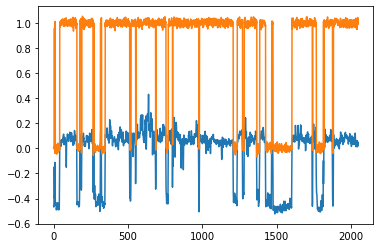

In [11]:
# Test plot
image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, preprocessed_data, markers)
print(image_batch.shape)
plt.plot(image_batch[0,0,:,:])
plt.plot(image_batch[0,1,:,:])
plt.show()

In [ ]:
#Each "epoch", of course a batch of 100 records.
train(preprocessed_data, 10000, markers, 2445)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Starting Training


  7%|█████▋                                                                            | 7/100 [00:12<02:09,  1.39s/it]

In [ ]:
gen_loss_list=[]
disc_loss_list=[]

## Various manipulations and outputs.

In [ ]:
epoch=0
x,y=[],[]
batches=2
for _ in range(batches):
    data=make_images(generator, epoch, gen_loss_list=[], disc_loss_list=[],plot=False)
    np.save("data.npy", data)
    '''data = unscale_images(data.reshape(BATCH_SIZE,2,WINDOW_SIZE,1)).reshape((BATCH_SIZE,2,WINDOW_SIZE))'''
    for record in range(len(data[:,0,0])):
        x.extend([pt for pt in data[record,0,:]])
    for record in range(len(data[:,0,0])):
        y.extend([pt for pt in data[record,1,:]])

print('length of data strip is',len(x))
plt.subplot(2,2,1)
n, bins, patches =plt.hist(x,bins=100)
    
plt.subplot(2,2,2)
n, bins, patches =plt.hist(y,bins=100)
plt.vlines(-0.01,0,15000,"red")
plt.subplot(2,2,3)
plt.plot(x[:20000])
plt.subplot(2,2,4)
plt.plot(y[:20000])
#plt.xlim([0,0.4])

#plt.ylim([0,11000])
datadf = {'1cur':x,
        '2chan': y}
df = pd.DataFrame (datadf, columns = ['1cur','2chan'])

df.to_csv(f'{WINDOW_SIZE}lina11gen_data.csv', index =False, header=False)
print(np.mean(np.asarray(x)))
print(max(y))

print(y.count(2))

In [ ]:
start = time.time()
for epoch in range(0):  
    x=make_images(generator, epoch, gen_loss_list=[], disc_loss_list=[],plot=False)
    if epoch%1==0:
        # Console outputs
        clear_output(wait=True)
        print(f"Time for epoch {epoch} is {(time.time() - start)/BATCH_SIZE}s.")
        start = time.time()

## If you wish to reload a previous checkpoint and retrain or just simulate
edit this cell.

In [ ]:
checkpoint.restore('checkpoints/checkpoint_-587').assert_existing_objects_matched()
make_images(generator, 0, gen_loss_list=[], disc_loss_list=[],plot=False)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(generator, to_file='generator.png')
generator.summary()
plot_model(discriminator, to_file='discriminator.png')
discriminator.summary()